**Key Audio Features in Audio Classification**

MFCC (Mel-Frequency Cepstral Coefficients)
  MFCCs are widely used features in speech and audio classification.
* They represent the power spectrum of a sound signal on a Mel scale, which mimics human auditory perception.



Spectral Contrast

* Detects differences in harmonics and background noise, helping distinguish real vs. synthetic audio.

In [1]:
# Required Modules

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

**1. Dataset**

* Taken Data from,
* https://www.kaggle.com/datasets/mohammedabdeldayem/the-fake-or-real-dataset
* Added as input to kaggle notebook

In [2]:
# Taking norm folder for the analysis

os.chdir("/kaggle/input/for-norm/for-norm/")

In [3]:
os.listdir()

['validation', 'training', 'testing']

In [4]:
os.listdir("training")

['fake', 'real']

In [5]:
os.listdir("training/real")[0:5]

['file30736.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file25321.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file20017.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file31620.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file8127.wav_16k.wav_norm.wav_mono.wav_silence.wav']

In [6]:
os.listdir("training/fake")[0:5]

['file14215.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file25706.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file11746.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file25410.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'file31620.wav_16k.wav_norm.wav_mono.wav_silence.wav']

In [7]:
def count_files(path):
    return {cls: len([f for f in os.listdir(os.path.join(path, cls)) if os.path.isfile(os.path.join(path, cls, f))]) for cls in ['real', 'fake']}

for split in ['training', 'testing']:
    print(f"\n🔹 {split.capitalize()} Data")
    counts = count_files(f"/kaggle/input/for-norm/for-norm/{split}")
    for label, count in counts.items():
        print(f"{label.capitalize()}: {count}")



🔹 Training Data
Real: 26941
Fake: 26927

🔹 Testing Data
Real: 2264
Fake: 2370


In [8]:
import librosa

# Duration summary for real audio
real_durations = []
real_path = 'training/real'
for file in os.listdir(real_path)[:100]:  # sample first 100 for speed
    y, sr = librosa.load(os.path.join(real_path, file))
    real_durations.append(librosa.get_duration(y=y, sr=sr))

# Duration summary for fake audio
fake_durations = []
fake_path = 'training/fake'
for file in os.listdir(fake_path)[:100]:
    y, sr = librosa.load(os.path.join(fake_path, file))
    fake_durations.append(librosa.get_duration(y=y, sr=sr))

print(f"Real - Min: {min(real_durations):.2f}s, Max: {max(real_durations):.2f}s, Avg: {sum(real_durations)/len(real_durations):.2f}s")
print(f"Fake - Min: {min(fake_durations):.2f}s, Max: {max(fake_durations):.2f}s, Avg: {sum(fake_durations)/len(fake_durations):.2f}s")


Real - Min: 1.16s, Max: 9.94s, Avg: 4.66s
Fake - Min: 0.46s, Max: 3.83s, Avg: 1.66s


**X & y**

In [9]:
# Function to extract features (MFCC + Spectral Contrast)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCCs (flatten to 1D)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    
    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast = np.mean(spectral_contrast.T, axis=0)
    
    # Combine both features
    return np.hstack((mfccs, spectral_contrast))

In [10]:
# Prepare dataset
X, y = [], []
data_dir = "training/"  # Folder containing 'real/' and 'fake/' subfolders

labels_dict = {"real": 0, "fake": 1}  # 0 = Real, 1 = Fake

for label, label_id in labels_dict.items():
    folder_path = os.path.join(data_dir, label)
    for file in os.listdir(folder_path)[0:1000]:
        file_path = os.path.join(folder_path, file)
        features = extract_features(file_path)
        X.append(features)
        y.append(label_id)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

**Train-Test Split**

In [11]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((1600, 47), (1600,))

**Model Define**

In [13]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout

model = Sequential([
    Input(shape=(X_train.shape[1],)),       # Define input shape explicitly
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")          # Binary classification
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.F1Score(),
                                                                tf.keras.metrics.Precision(),
                                                                tf.keras.metrics.Recall()])


**Model Training**

In [14]:
from keras.callbacks import  ModelCheckpoint



MC = ModelCheckpoint(
    '/kaggle/working/deepfake/ann.keras', # You also can provide full path to the folder you want to save your model to
    monitor='val_loss',  # Monitor other things like val_accuracy or accuracy 
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import numpy as np

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)


In [17]:
# Train the model
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[MC])

Epoch 1/50
27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5480 - f1_score: 0.6507 - loss: 7.7592 - precision: 0.5787 - recall: 0.5364  
Epoch 1: val_loss improved from inf to 0.88200, saving model to /kaggle/working/deepfake/ann.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5594 - f1_score: 0.6552 - loss: 6.5469 - precision: 0.5769 - recall: 0.5444 - val_accuracy: 0.7350 - val_f1_score: 0.6689 - val_loss: 0.8820 - val_precision: 0.6955 - val_recall: 0.8408
Epoch 2/50
29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - f1_score: 0.7104 - loss: 2.2137 - precision: 0.6507 - recall: 0.6503 
Epoch 2: val_loss improved from 0.88200 to 0.66207, saving model to /kaggle/working/deepfake/ann.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6171 - f1_score: 0.6934 - loss: 2.0798 - precision: 0.6340 - recall: 0.6400 - val_accuracy: 0.6175 - val_f1_score: 0.6689 - val_loss: 0.6621 - val_precision: 0.7449 - val_recall: 0.3632
Epoch 3/50
27/50 ━━━━━━━━━━━━━━━━━━━

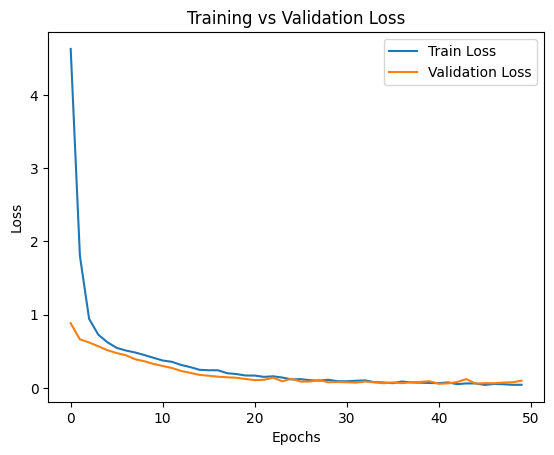

In [18]:
# Get number of epochs from training history
epochs = range(len(model.history.history['loss']))

# Plot training and validation loss
plt.plot(epochs, model.history.history['loss'], label="Train Loss")
plt.plot(epochs, model.history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

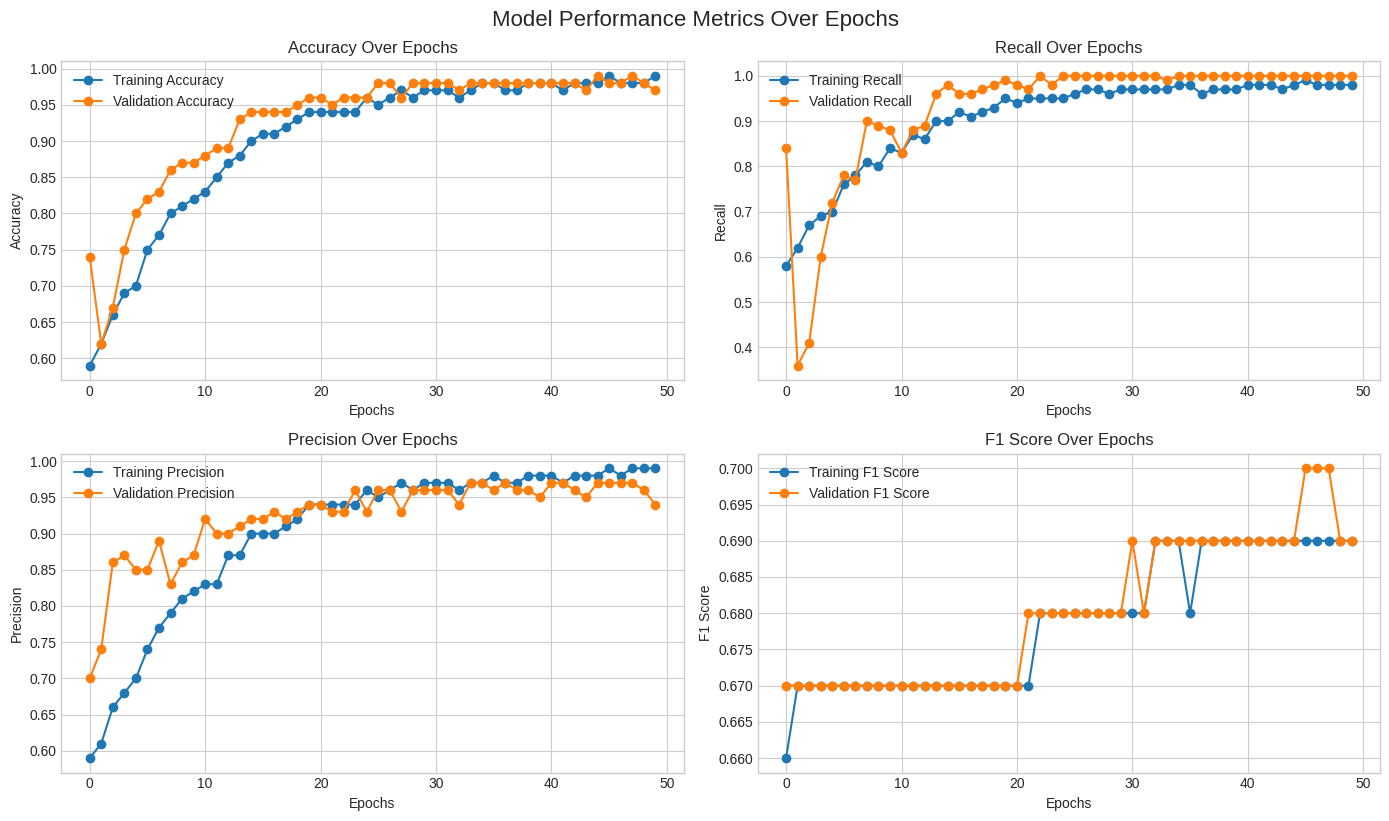

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')  # Cleaner style

epochs = np.arange(len(model.history.history['accuracy']))

# Accuracy
train_acc = [round(val, 2) for val in model.history.history['accuracy']]
val_acc = [round(val, 2) for val in model.history.history['val_accuracy']]

# Precision
train_pre = [round(val, 2) for val in model.history.history['precision']]
val_pre = [round(val, 2) for val in model.history.history['val_precision']]

# Recall
train_rec = [round(val, 2) for val in model.history.history['recall']]
val_rec = [round(val, 2) for val in model.history.history['val_recall']]

# F1 Score
train_f1 = [round(val, 2) for val in model.history.history['f1_score']]
val_f1 = [round(val, 2) for val in model.history.history['val_f1_score']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

metrics = {
    "Accuracy Over Epochs": (train_acc, val_acc, "Accuracy"),
    "Recall Over Epochs": (train_rec, val_rec, "Recall"),
    "Precision Over Epochs": (train_pre, val_pre, "Precision"),
    "F1 Score Over Epochs": (train_f1, val_f1, "F1 Score")
}

for ax, (title, (train_vals, val_vals, ylabel)) in zip(axes.flat, metrics.items()):
    ax.plot(epochs, train_vals, label=f"Training {ylabel}", marker='o')
    ax.plot(epochs, val_vals, label=f"Validation {ylabel}", marker='o')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Model Performance Metrics Over Epochs", fontsize=16, y=1.02)
plt.show()

In [21]:
import pandas as pd
from tabulate import tabulate  # Make sure to install tabulate via pip if not already installed

# Get number of epochs
epochs = np.arange(len(model.history.history['accuracy']))

# Build a DataFrame
metrics_df = pd.DataFrame({
    "Epoch": epochs + 1,
    "Train Accuracy": model.history.history['accuracy'],
    "Val Accuracy": model.history.history['val_accuracy'],
    "Train Precision": model.history.history['precision'],
    "Val Precision": model.history.history['val_precision'],
    "Train Recall": model.history.history['recall'],
    "Val Recall": model.history.history['val_recall'],
    "Train F1 Score": model.history.history['f1_score'],
    "Val F1 Score": model.history.history['val_f1_score']
}).round(4)

# Display as a pretty table
print(tabulate(metrics_df.head(10), headers='keys', tablefmt='grid'))

+----+---------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------------+----------------+
|    |   Epoch |   Train Accuracy |   Val Accuracy |   Train Precision |   Val Precision |   Train Recall |   Val Recall |   Train F1 Score |   Val F1 Score |
+====+=========+==================+================+===================+=================+================+==============+==================+================+
|  0 |       1 |           0.5869 |         0.735  |            0.5882 |          0.6955 |         0.5757 |       0.8408 |           0.6646 |         0.6689 |
+----+---------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------------+----------------+
|  1 |       2 |           0.615  |         0.6175 |            0.6125 |          0.7449 |         0.6233 |       0.3632 |           0.6675 |         0.6689 |
+----+---------+------------------+-----------

**Model Evaluation**

**Prediction**

In [23]:
model = tf.keras.models.load_model("/kaggle/working/deepfake/ann.keras")

In [24]:
def predict_audio(file_path, model):
    features = extract_features(file_path).reshape(1, -1)
    prediction = model.predict(features)[0][0]  # Get scalar probability from 2D array

    label = "Real" if prediction >= 0.5 else "Fake"
    return f"Prediction: {label} (Probability: {prediction:.2f})"

# Test with a new file
print(predict_audio("/kaggle/input/for-norm/for-norm/testing/fake/file10.wav_16k.wav_norm.wav_mono.wav_silence.wav", model))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Prediction: Real (Probability: 0.96)
